# Surface visualization in 3D

Created by: Bernard Chang, Masa Prodanovic and James McClure

Updated: March 2022

## Motivation

Segmented (also sometimes binary) images are those where each pixel or voxel has been classified as a member of a finite number of groups (phases, physical objects, elements or whatever is of interest to identify).

We will here not spend more on the subject of segmentation (extremely important one!), but will use one such segmented image to plot surfaces between different phases (e.g. fluids, mineral phases in subsurface porous media) has already been made.

In 3D, it is very useful to draw surface that separates two phases or it is placed at an interpolated "level" of data. It is also called isosurface.

## Import some useful packages


In [1]:
import requests # library for file download

import numpy as np
import skimage.transform

import matplotlib.pyplot as plt
import pyvista as pv

## Useful functions for download and statistics

In [2]:
def download_file_url(file_url,filename):

    # download file
    r = requests.get(file_url, stream = True) 

    with open(filename,"wb") as f: 
        for chunk in r.iter_content(chunk_size=1024): 

             # writing one chunk at a time to pdf file 
             if chunk: 
                 f.write(chunk)
    return



def image_statistics(image, plot_histogram=False):
    print('\nImage (ndarray) shape',image.shape)
    print('\nImage data type',image.dtype)

    # This is a 2D image, and min, max and mean functions are programmed to work by dimension. 
    # So we will reshape the array. 
    # Be mindful that below we are on purpose creating another copy of the array (and doubles the memory use)
    dims = image.shape;
    reshaped_image = np.copy(image) 
    reshaped_image.shape = (np.prod(dims),)

    # min, max, mean are functions that are built into ndarray class in NumPy. If we call them such as in example below,
    # then they will execute on the ndarray reshaped_image
    print('\nImage values min:', reshaped_image.min(), 'max:',reshaped_image.max(), 'mean:',reshaped_image.mean())

    if plot_histogram:
        #Histogram
        # histogram has 256 bins, is normalized (density=True),
        # so that comparison with other images of different size is possible and is shown in green color
        plt.hist(reshaped_image, 256, density=True, facecolor='g', alpha=0.75)

        plt.xlabel('Image value')
        plt.ylabel('Probability')

        #plt.axis([40, 160, 0, 0.03])
        plt.grid(True)
        plt.show()

    return

## Example from DRP

We will download Digital Rocks Portal Example for the purpose from https://www.digitalrocksportal.org/projects/125/analysis_data/187/

In [3]:
# File download

file_url = "https://www.digitalrocksportal.org/projects/125/images/101255/download/"
filename = "Ketton_segmented_oil_blob.raw"

download_file_url(file_url,filename)

In [4]:
# Read downloaded file.

# the file is binary (.raw) file, 
# and requires information from the webpage on how to read it.
width  = 365
height = 255
slices = 225

# Alternative
#dtype  = 'u1'
#byte = '<'  # little endian byte order
# read date from file
#datatype = byte + dtype    

alldata = np.fromfile(filename, dtype=np.ubyte, sep="")
image = alldata.reshape([slices, height, width])

In [5]:
print('Original image stats\n')
image_statistics(image, plot_histogram=False)

# need to downsample image since it is too large
# Note - if I provide integer image below, then rescaling 
# shifts the image values even if I preserve_range (i.e. set it to True). 
# Hence I do a type conversion (image.astype(float))
# Likely culprit:
# Some online sites warn that skimage converts all floats to [-1,1]
# and many functions return float even if they get integer array.
image_rescaled  = skimage.transform.rescale(image.astype(float), 0.5, preserve_range=True)

# check stats on rescaled image to make sure the values are preserved
image_statistics(image_rescaled, plot_histogram=False)

# resizing has the same trouble with integer array input, 
# so would have to use image.astype(float) conversion

#factor = 2
#image_resized = skimage.transform.resize(image,[width/factor,height/factor, slices/factor])
#image_statistics(image_resized,plot_histogram=False)

Original image stats


Image (ndarray) shape (225, 255, 365)

Image data type uint8

Image values min: 1 max: 3 mean: 2.7589871967051662

Image (ndarray) shape (112, 128, 182)

Image data type float64

Image values min: 0.9999999999999998 max: 2.999999999999999 mean: 2.758989161169739


### Matplotlib

A quick check to see what a slice through our Ketton limestone image looks like

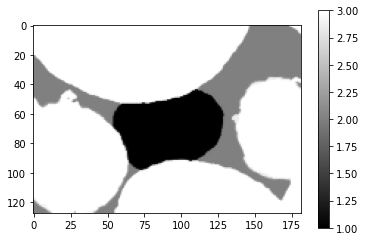

In [6]:
plt.imshow(image_rescaled[50,:,:], cmap='gray')
plt.colorbar()

### PyVista

Now for the fun stuff...

Here, we will exemplify PyVista — an open-source, Python library that provides toolsets for 3D Visualization and mesh analysis. Though there are several other available 3D visualization libraries (e.g. Vedo, Mayavi, Matplotlib, etc.), PyVista is currently stable across all computing platforms and provides relatively clear documentation.

Documentation:
https://docs.pyvista.org/

In [7]:
# Enable interactive plotting within a Jupyter notebook
pv.set_jupyter_backend('pythreejs')


# A function to initialize a PyVista Plotter Object
def initialize_plotter():
    
    # Initialize a PyVista Plotter Object
    plotter_obj = pv.Plotter()
    
    # Set the background color to white
    plotter_obj.set_background(color='w')
    
    return plotter_obj


# Wrap 3D NumPy array to PyVista data object
pv_img = pv.wrap(image_rescaled)

#### Our first PyVista plot
Here, we will create our first 3D plot in PyVista — we will visualize three orthogonal slices through the image. 

The workflow for creating any PyVista plot can be generalized as follows:

1. Make sure the data you want to plot is a PyVista data object. We used the wrap function in the cell above to convert a NumPy array into the PyVista data object. Depending on how your data is formatted to begin with (e.g. VTK object), you may need to find alternate methods of creating a PyVista data object.
    
2. Initialize a plotter object

3. Create a mesh for the data you wish to plot (e.g. orthogonal slices, isosurfaces, etc.) and add the mesh to the plotter object

4. Use the ```show()``` function to display the plot in a self-contained plotter 

In [8]:
# A function that plots orthogonal slices through the 3D image
def plot_orthogonal_slices(pv_image_obj, x_slice, y_slice, z_slice):
    ################################################################################ 
    # Input: PyVista image object (wrapped NumPy array), x, y, and z slices to plot
    # Output: PyVista plot of orthogonal slices
    ################################################################################
    
    # Initialize the PyVista plotter object
    p = initialize_plotter()
    
    # Tests to make sure input slices are within image dimensions
    assert x_slice > 0 and x_slice < pv_image_obj.dimensions[0], "X-slice value outside image dimensions"
    assert y_slice > 0 and y_slice < pv_image_obj.dimensions[1], "Y-slice value outside image dimensions"
    assert z_slice > 0 and z_slice < pv_image_obj.dimensions[2], "Z-slice value outside image dimensions"
    
    # Create three orthogonal slices through the dataset at specified X, Y, and Z values
    slices = pv_image_obj.slice_orthogonal(x=x_slice, y=y_slice, z=z_slice)
    
    # Add the slices as meshes to the PyVista plotter object
    p.add_mesh(slices)
    
    p.show()


# Get dimensions of the rescaled image
x_dim, y_dim, z_dim = pv_img.dimensions

# Function call to plot the orthogonal slices.
plot_orthogonal_slices(pv_img, x_dim//2 , y_dim//2, z_dim//2)


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(color='#fefefe', inten…

#### Plot just the oil blob

In the segmented image, we have 1, 2 and 3 represent oil, brine and rock respectively.

The interpolated value of 1.5 separated oil from everything else.

In [9]:
# Initialize a Plotter object
p = initialize_plotter()

oil_isosurface = pv_img.contour(isosurfaces=[1.5])
p.add_mesh(oil_isosurface, color=(0, 0.8, 0.27), opacity=1)
p.show()


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(color='#fefefe', inten…

#### Plot just the pore space

Recall that the segmented image represents oil, brine and rock with values of 1, 2 and 3 respectively.
The surface passing through points where interpolated image values are 2.5 is a surface that separates both fluids and the rock. 



In [10]:
# Initialize a Plotter object
p = initialize_plotter()

grain_isosurface = pv_img.contour(isosurfaces=[2.5])
p.add_mesh(grain_isosurface, color=(0.7, 0.95, 1), opacity=0.8)
p.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(color='#fefefe', inten…

#### Plot oil blob and grain surface

To plot the oil blob and grain surface together (and any other phase that might be present), you can simply keep adding meshes to the same initial plotter object. 

In [11]:
# Initialize a Plotter object
p = initialize_plotter()

oil_surface = pv_img.contour(isosurfaces=[1.5])
p.add_mesh(oil_surface, color=(0, 1, 0), opacity=1)

grain_surface = pv_img.contour(isosurfaces=[2.5])
p.add_mesh(grain_surface, color=(1, 1, 1), opacity=0.5)


p.show_axes()
p.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(color='#fefefe', inten…